In [13]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import PIL.Image
import io

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const btn = document.createElement('button');
            btn.textContent = 'Capture Image';
            div.appendChild(video);
            div.appendChild(btn);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => (video.onloadedmetadata = resolve));
            video.play();

            await new Promise((resolve) => btn.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const ctx = canvas.getContext('2d');
            ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

# Take a photo
image_path = take_photo()
print(f"Image saved as {image_path}")


<IPython.core.display.Javascript object>

Image saved as photo.jpg


In [14]:
!pip install opencv-python mediapipe numpy

Enter your height in cm: 171
✅ Estimated Shoulder Width: 29.80 cm
✅ Estimated Bust Width: 27.02 cm
✅ Estimated Waist Width: 23.15 cm
✅ Estimated Hip Width: 28.11 cm


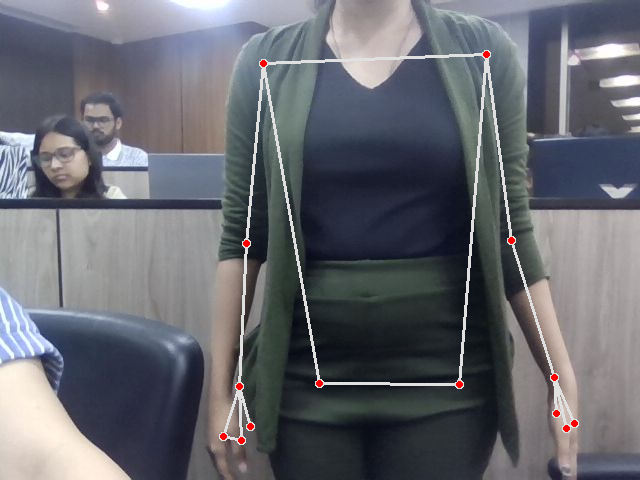

In [23]:
import mediapipe as mp
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Load the captured image
image = cv2.imread("photo.jpg")

# Convert image to RGB (required by MediaPipe)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process with Pose Estimation
results = pose.process(image_rgb)

if results.pose_landmarks:
    # Draw landmarks on image
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Extract key points for measurement
    landmarks = results.pose_landmarks.landmark
    left_shoulder = (landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y)
    right_shoulder = (landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y)
    left_hip = (landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y)
    right_hip = (landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y)
    top_head = (landmarks[mp_pose.PoseLandmark.NOSE.value].x, landmarks[mp_pose.PoseLandmark.NOSE.value].y)
    feet = (landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y)

    # Approximate bust using midpoint between shoulders and hips
    left_bust = (left_shoulder[0] * 0.75 + left_hip[0] * 0.25, left_shoulder[1] * 0.75 + left_hip[1] * 0.25)
    right_bust = (right_shoulder[0] * 0.75 + right_hip[0] * 0.25, right_shoulder[1] * 0.75 + right_hip[1] * 0.25)

    # Approximate waist using a point between the bust and hips
    left_waist = (left_shoulder[0] * 0.4 + left_hip[0] * 0.6, left_shoulder[1] * 0.4 + left_hip[1] * 0.6)
    right_waist = (right_shoulder[0] * 0.4 + right_hip[0] * 0.6, right_shoulder[1] * 0.4 + right_hip[1] * 0.6)

    # Extend hip measurement to the PELVIC WIDTH

    left_outer_thigh = (left_hip[0], left_hip[1])
    right_outer_thigh = (right_hip[0], right_hip[1])

    # Correct distance calculation function
    def calculate_distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    # Get pixel measurements
    shoulder_width_px = calculate_distance(left_shoulder, right_shoulder)
    hip_width_px = calculate_distance(left_outer_thigh, right_outer_thigh)*1.5  # Improved hip width
    bust_width_px = calculate_distance(left_bust, right_bust)
    waist_width_px = calculate_distance(left_waist, right_waist)
    body_height_px = calculate_distance(top_head, feet)  # Full body pixel height

    # Ask user for their real height in cm
    user_height_cm = float(input("Enter your height in cm: "))

    # Convert pixel distances to real-world cm
    shoulder_width_cm = (shoulder_width_px / body_height_px) * user_height_cm
    hip_width_cm = (hip_width_px / body_height_px) * user_height_cm
    bust_width_cm = (bust_width_px / body_height_px) * user_height_cm
    waist_width_cm = (waist_width_px / body_height_px) * user_height_cm

    # Display results
    print(f"✅ Estimated Shoulder Width: {shoulder_width_cm:.2f} cm")
    print(f"✅ Estimated Bust Width: {bust_width_cm:.2f} cm")
    print(f"✅ Estimated Waist Width: {waist_width_cm:.2f} cm")
    print(f"✅ Estimated Hip Width: {hip_width_cm:.2f} cm")

# Show the processed image with landmarks
cv2_imshow(image)
